In [28]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
import time 

In [ ]:
import torch
from torch.optim import Optimizer
import math
from collections import defaultdict

class AdamSGDDFWWeighted(Optimizer):
    r"""Implements Adam, SGD and DFE mix algorithm.
    """

    def __init__(self,
                 params, lr=1e-3, weight_decay=0,
                 betas=(0.9, 0.999), eps=1e-8, amsgrad=False,
                 momentum=0, dampening=0, nesterov=False,
                 adam_w=0.3, sgd_w=0.3, dfw_w = 0.3):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(
            lr=lr, weight_decay=weight_decay,
            betas=betas, eps=eps, amsgrad=amsgrad,
            momentum=momentum, dampening=dampening, nesterov=nesterov,
            adam_w=adam_w, sgd_w=sgd_w, dfw_w=dfw_w
        )
        super(AdamSGDDFWWeighted, self).__init__(params, defaults)
        self.eps = eps

    def __setstate__(self, state):
        super(AdamSGDDFWWeighted, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('AdamSGDDFEWeighted does not support sparse gradients')

                d_p_adam, step_size = self.adam_step(grad, group, p)

                d_p_sgd = self.sgd_step(grad, group, p)
                
                d_p_dfw = self.dfw_step(closure, grad, group, p)
                print(f'[{d_p_adam}, {d_p_sgd}, {d_p_dfw}],')
                megred_d_p = group['sgd_w'] * d_p_sgd + group['adam_w'] * d_p_adam + group['dfw_w'] * d_p_dfw
                # print(f'[{d_p_adam}, {d_p_sgd}, {megred_d_p}],')
                merged_lr = group['sgd_w'] * group['lr'] + group['adam_w'] * step_size + group['dfw_w'] * group['lr']

                p.add_(megred_d_p, alpha=-merged_lr)

        return loss

    def adam_step(self, grad, group, p):
        amsgrad = group['amsgrad']
        state = self.state[p]
        # State initialization
        if len(state) == 0:
            state['step'] = 0
            # Exponential moving average of gradient values
            state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            # Exponential moving average of squared gradient values
            state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
            if amsgrad:
                # Maintains max of all exp. moving avg. of sq. grad. values
                state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
        if amsgrad:
            max_exp_avg_sq = state['max_exp_avg_sq']
        beta1, beta2 = group['betas']
        state['step'] += 1
        bias_correction1 = 1 - beta1 ** state['step']
        bias_correction2 = 1 - beta2 ** state['step']
        if group['weight_decay'] != 0:
            grad = grad.add(p, alpha=group['weight_decay'])
        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])
        step_size = group['lr'] / bias_correction1

        d_p = exp_avg / denom
        return d_p, step_size

    def sgd_step(self, grad, group, p):
        d_p = grad
        weight_decay = group['weight_decay']
        momentum = group['momentum']
        dampening = group['dampening']
        nesterov = group['nesterov']
        if weight_decay != 0:
            d_p = d_p.add(p, alpha=weight_decay)
        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf

        return d_p
    
    def dfw_step(self, closure, grad, group, p):
        
        loss = float(closure())
        
        w_dict = defaultdict(dict)
        for group in self.param_groups:
            wd = group['weight_decay']
            for param in group['params']:
                if param.grad is None:
                    continue
                w_dict[param]['delta_t'] = param.grad.data
                w_dict[param]['r_t'] = wd * param.data
        self._line_search(loss, w_dict)

        eta = group['lr']
        momentum = group['momentum']

        state = self.state[param]
        delta_t, r_t = w_dict[param]['delta_t'], w_dict[param]['r_t']
        d_p = r_t + self.gamma * delta_t

        if momentum != 0:
            param_state = self.state[p]
            if 'momentum_buffer' not in param_state:
                buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
            else:
                buf = param_state['momentum_buffer']
                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
            if nesterov:
                d_p = d_p.add(buf, alpha=momentum)
            else:
                d_p = buf
        return d_p
    
    @torch.autograd.no_grad()
    def _line_search(self, loss, w_dict):
        """
        Computes the line search in closed form.
        """

        num = loss
        denom = 0

        for group in self.param_groups:
            eta = group['lr']
            for param in group['params']:
                if param.grad is None:
                    continue
                delta_t, r_t = w_dict[param]['delta_t'], w_dict[param]['r_t']
                num -= eta * torch.sum(delta_t * r_t)
                denom += eta * delta_t.norm() ** 2

        self.gamma = float((num / (denom + self.eps)).clamp(min=0, max=1))

In [11]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [29]:
device = torch.device('cpu')

In [30]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [31]:
mnist_train = mnist_trainset.data
mnist_test = mnist_testset.data

mnist_trainlabel = mnist_trainset.targets
mnist_testlabel = mnist_testset.targets

mnist_train = mnist_train.to(device)
mnist_test = mnist_test.to(device)
mnist_trainlabel = mnist_trainlabel.to(device)
mnist_testlabel = mnist_testlabel.to(device)

In [32]:
print(mnist_train.shape)
print(mnist_test.shape)
print(mnist_trainlabel.shape)
print(mnist_testlabel.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


In [33]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, 10) 


    def forward(self, x):
        x = x.view(-1,784) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [34]:
def accuracy(y_pred,y_ground):
    return (torch.sum(torch.argmax(y_pred,axis=1) == y_ground) / y_ground.size(0)).item()

In [35]:
def train(model, train_input, train_target, test_input, test_target, mini_batch_size, nb_epochs = 100, eta = 1e-3, verbose=False, adam_w=0.5, sgd_w=0.5):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamSGDWeighted(model.parameters(), lr=eta, momentum=0, adam_w=adam_w, sgd_w=sgd_w)
    #optimizer = torch.optim.SGD(model.parameters(), eta, momentum=0)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1, verbose=False)
    
    history = {}
    history['loss'] = []
    history['loss_val'] = []
    history['acc'] = []
    history['acc_val'] = []
    
    for e in range(nb_epochs):
        total_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b , min(mini_batch_size, train_input.size(0)-b)))
            loss = criterion(output, train_target.narrow(0, b, min(mini_batch_size, train_input.size(0)-b)))
            total_loss = total_loss + loss.item()

            optimizer.zero_grad()
            loss.backward()
            #optimizer.step()
            optimizer.step(lambda: float(loss))
        
        output_train = model(train_input.float())
        output_val = model(test_input.float())
            
        accuracy_train = accuracy(output_train, train_target)
        accuracy_val = accuracy(output_val, test_target)
        loss_train = criterion(output_train, train_target).item()
        loss_val = criterion(output_val, test_target).item()
            
        history['loss'].append(loss_train)
        history['loss_val'].append(loss_val)
        history['acc'].append(accuracy_train)
        history['acc_val'].append(accuracy_val)
        if verbose:
            print('Epoch %d/%d, Cross Entropy Loss: %.3f' %(e+1, nb_epochs, total_loss))
    
    return history
        

In [36]:
import time
import matplotlib.pyplot as plt
import numpy as np
from optimizer import *

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-3, 5e-3, 1e-4]
alphas = [1, 0, 0.5, 0.4, 0.6, 0.7, 0.3]
batch_size = 256

mesh = np.meshgrid(alphas, gammas)

for alpha,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('adam_w: {} | learning-rate: {}'.format(alpha,lr))
    # reset weights
    mlp = MLP().to(device)

    history = train(mlp, mnist_train.float(), mnist_trainlabel,
                mnist_test.float(), mnist_testlabel,
                mini_batch_size=batch_size,nb_epochs = 100,eta=lr,verbose=False, adam_w=alpha, sgd_w=1-alpha)
    
    histories.append(history)

adam_w: 1.0 | learning-rate: 0.001
adam_w: 0.0 | learning-rate: 0.001
adam_w: 0.5 | learning-rate: 0.001
adam_w: 0.4 | learning-rate: 0.001
adam_w: 0.6 | learning-rate: 0.001
adam_w: 0.7 | learning-rate: 0.001
adam_w: 0.3 | learning-rate: 0.001
adam_w: 1.0 | learning-rate: 0.005
adam_w: 0.0 | learning-rate: 0.005
adam_w: 0.5 | learning-rate: 0.005
adam_w: 0.4 | learning-rate: 0.005
adam_w: 0.6 | learning-rate: 0.005
adam_w: 0.7 | learning-rate: 0.005
adam_w: 0.3 | learning-rate: 0.005
adam_w: 1.0 | learning-rate: 0.0001
adam_w: 0.0 | learning-rate: 0.0001
adam_w: 0.5 | learning-rate: 0.0001
adam_w: 0.4 | learning-rate: 0.0001
adam_w: 0.6 | learning-rate: 0.0001
adam_w: 0.7 | learning-rate: 0.0001
adam_w: 0.3 | learning-rate: 0.0001


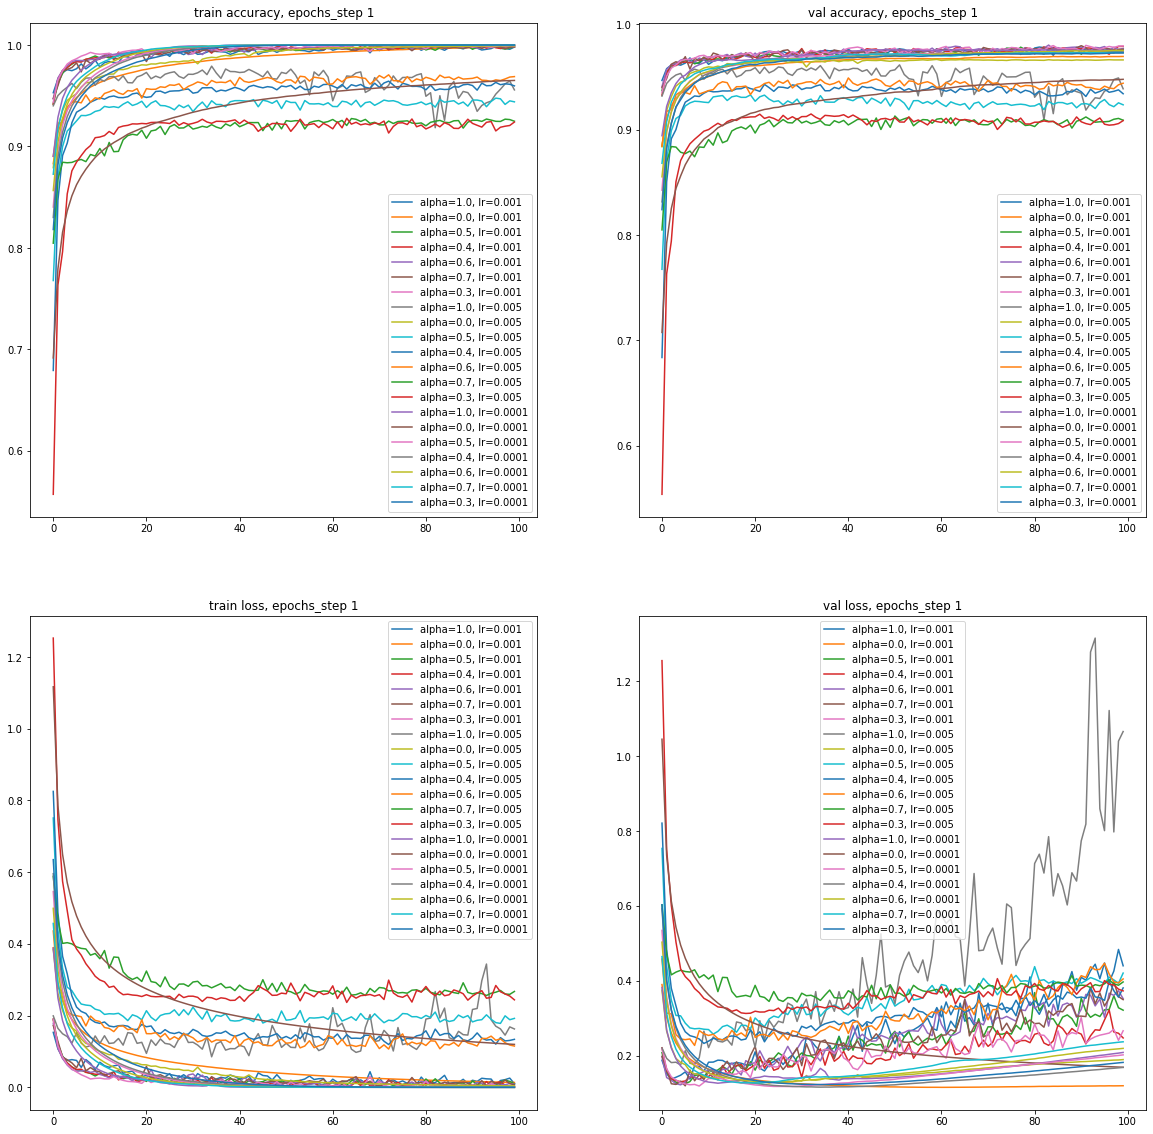

In [38]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
for j,(alpha,lr) in enumerate(zip(mesh[0].ravel(),mesh[1].ravel())):
  ax[0,0].plot([i for i in range(100)],histories[j]['acc'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[0,1].plot([i for i in range(100)],histories[j]['acc_val'],label='alpha={}, lr={}'.format(alpha,lr))

  ax[1,0].plot([i for i in range(100)],histories[j]['loss'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[1,1].plot([i for i in range(100)],histories[j]['loss_val'],label='alpha={}, lr={}'.format(alpha,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

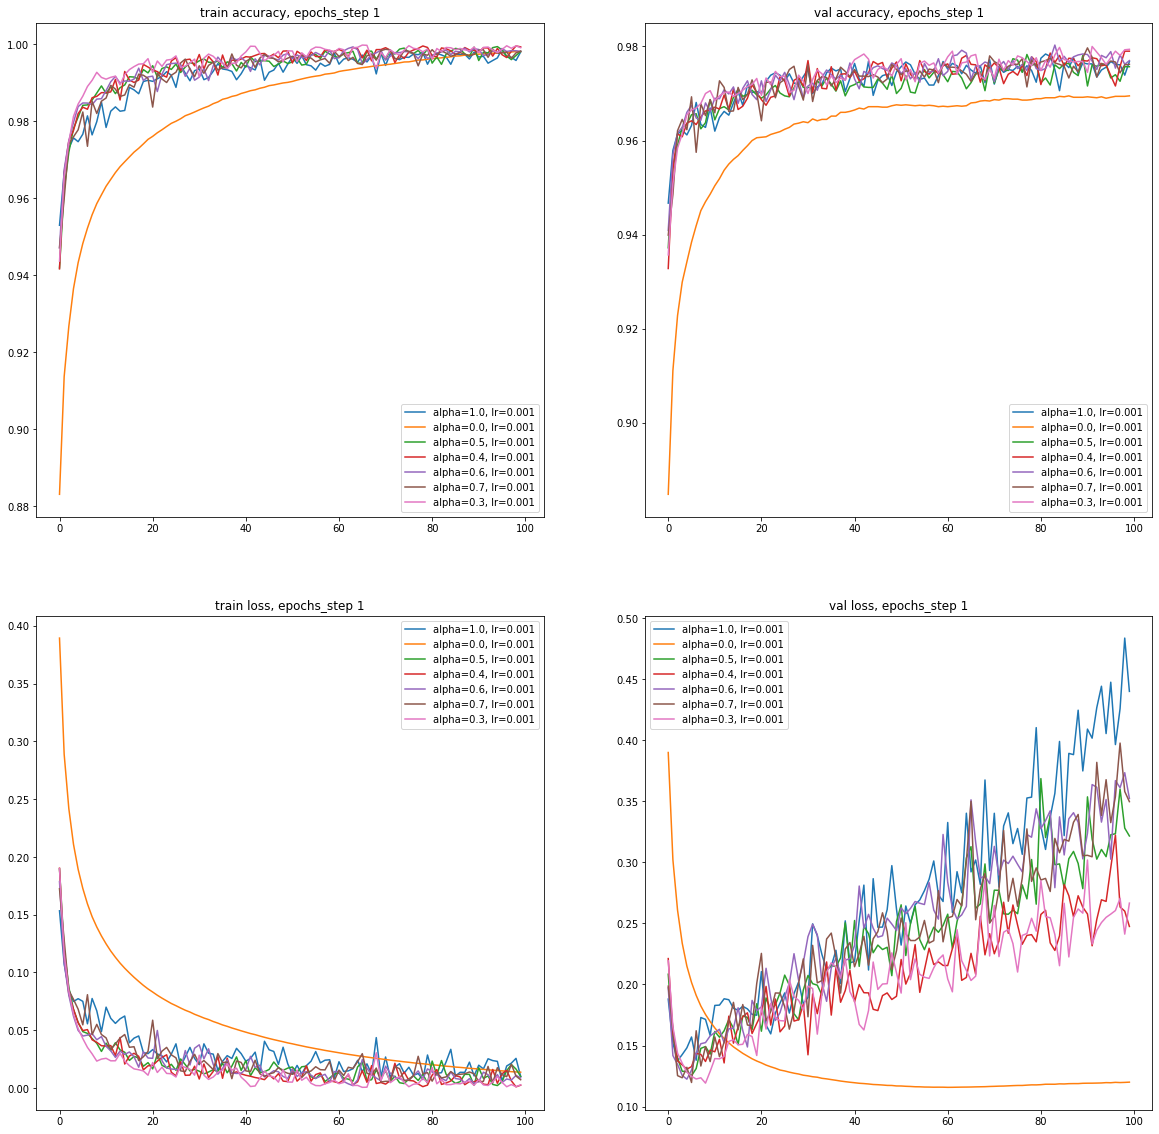

In [39]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
for j,(alpha,lr) in enumerate(zip(mesh[0].ravel(),mesh[1][0].ravel())):
  ax[0,0].plot([i for i in range(100)],histories[j]['acc'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[0,1].plot([i for i in range(100)],histories[j]['acc_val'],label='alpha={}, lr={}'.format(alpha,lr))

  ax[1,0].plot([i for i in range(100)],histories[j]['loss'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[1,1].plot([i for i in range(100)],histories[j]['loss_val'],label='alpha={}, lr={}'.format(alpha,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

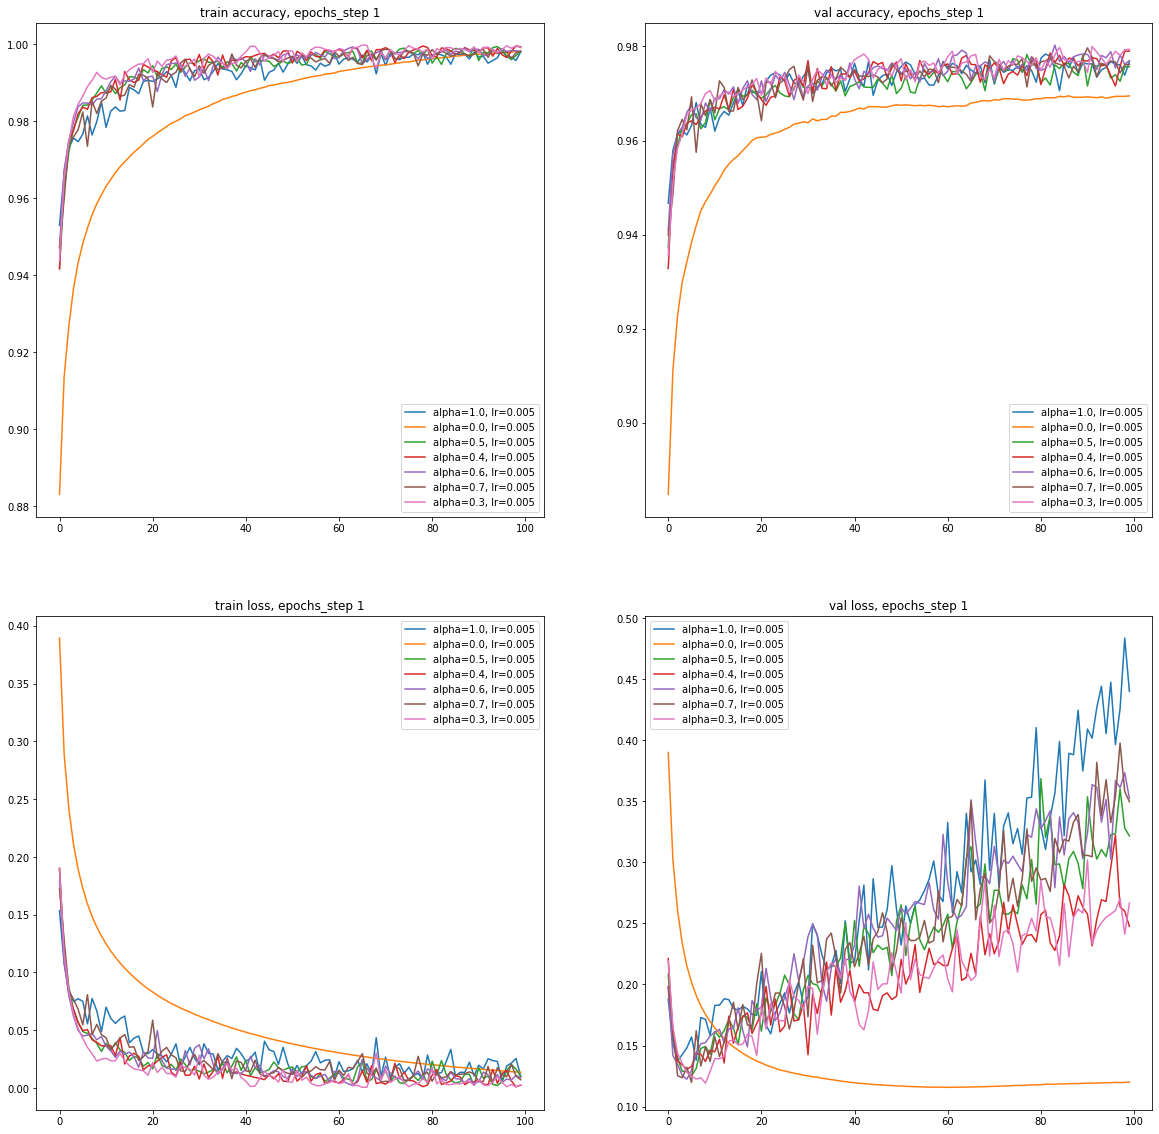

In [40]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
for j,(alpha,lr) in enumerate(zip(mesh[0].ravel(),mesh[1][1].ravel())):
  ax[0,0].plot([i for i in range(100)],histories[j]['acc'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[0,1].plot([i for i in range(100)],histories[j]['acc_val'],label='alpha={}, lr={}'.format(alpha,lr))

  ax[1,0].plot([i for i in range(100)],histories[j]['loss'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[1,1].plot([i for i in range(100)],histories[j]['loss_val'],label='alpha={}, lr={}'.format(alpha,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

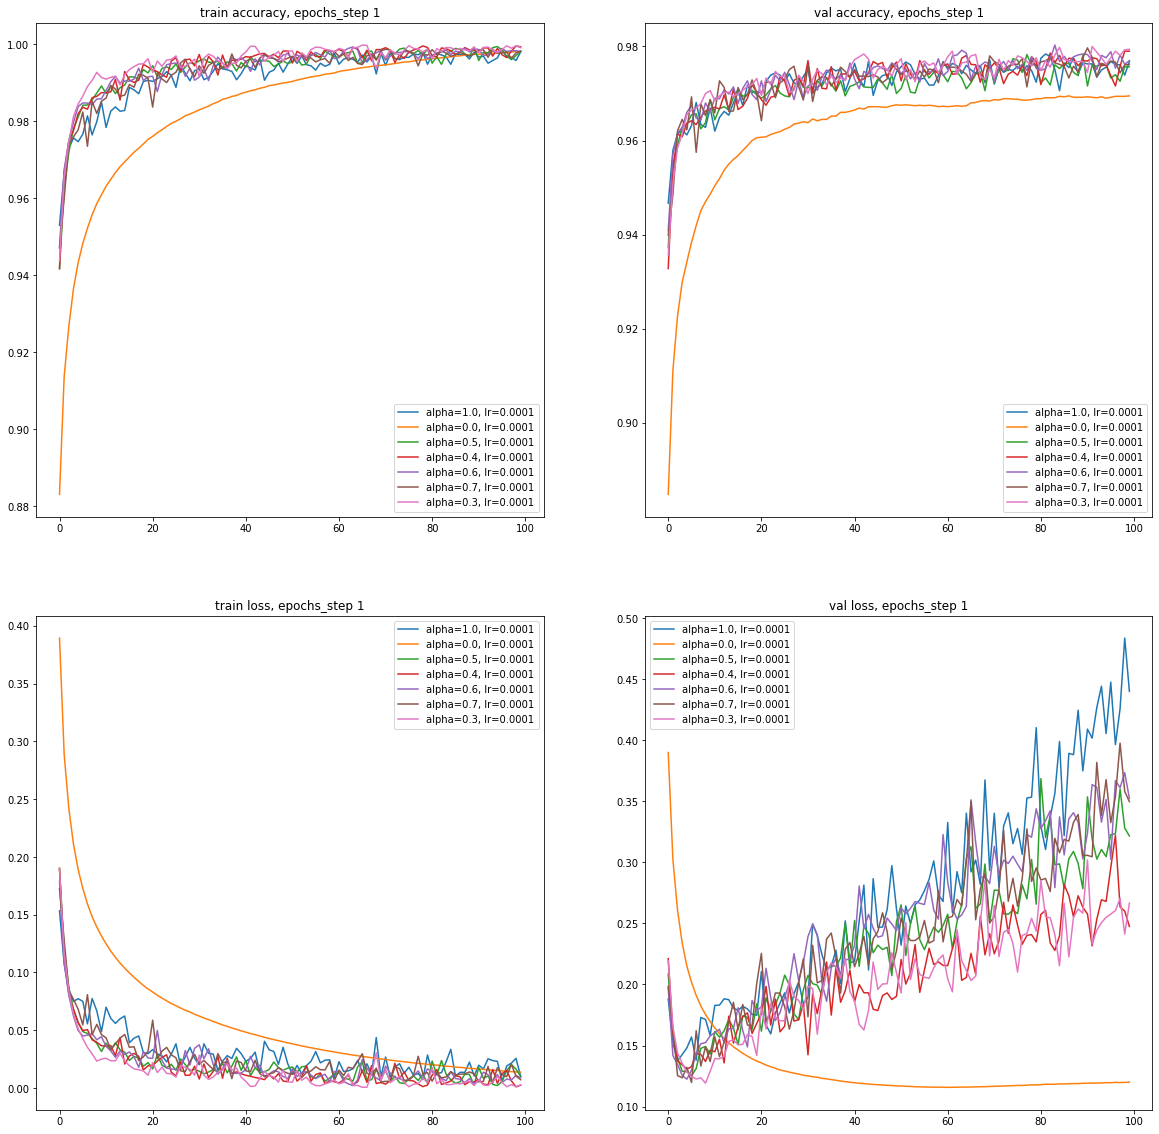

In [41]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
for j,(alpha,lr) in enumerate(zip(mesh[0].ravel(),mesh[1][2].ravel())):
  ax[0,0].plot([i for i in range(100)],histories[j]['acc'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[0,1].plot([i for i in range(100)],histories[j]['acc_val'],label='alpha={}, lr={}'.format(alpha,lr))

  ax[1,0].plot([i for i in range(100)],histories[j]['loss'],label='alpha={}, lr={}'.format(alpha,lr))
  ax[1,1].plot([i for i in range(100)],histories[j]['loss_val'],label='alpha={}, lr={}'.format(alpha,lr))

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_title('train accuracy, epochs_step 1')
ax[0,1].set_title('val accuracy, epochs_step 1')
ax[1,0].set_title('train loss, epochs_step 1')
ax[1,1].set_title('val loss, epochs_step 1')
plt.show()

In [ ]:
def train(model, train_input, train_target, test_input, test_target, mini_batch_size, nb_epochs = 100, eta = 1e-3, verbose=False, adam_w=0.3, sgd_w=0.3, dfw_w = 0.4):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamSGDDFWWeighted(model.parameters(), lr=eta, momentum=0, adam_w=adam_w, sgd_w=sgd_w, dfw_w=dfw_w)
    #optimizer = torch.optim.SGD(model.parameters(), eta, momentum=0)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1, verbose=False)
    
    history = {}
    history['loss'] = []
    history['loss_val'] = []
    history['acc'] = []
    history['acc_val'] = []
    
    for e in range(nb_epochs):
        total_loss = 0

        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b , min(mini_batch_size, train_input.size(0)-b)))
            loss = criterion(output, train_target.narrow(0, b, min(mini_batch_size, train_input.size(0)-b)))
            total_loss = total_loss + loss.item()

            optimizer.zero_grad()
            loss.backward()
            #optimizer.step()
            optimizer.step(lambda: float(loss))
        
        output_train = model(train_input.float())
        output_val = model(test_input.float())
            
        accuracy_train = accuracy(output_train, train_target)
        accuracy_val = accuracy(output_val, test_target)
        loss_train = criterion(output_train, train_target).item()
        loss_val = criterion(output_val, test_target).item()
            
        history['loss'].append(loss_train)
        history['loss_val'].append(loss_val)
        history['acc'].append(accuracy_train)
        history['acc_val'].append(accuracy_val)
        if verbose:
            print('Epoch %d/%d, Cross Entropy Loss: %.3f' %(e+1, nb_epochs, total_loss))
    
    return history
        

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
from adam_sgd_dfw_mix import *

torch.manual_seed(123456789) # seeding for weight initialization and train

histories = []

gammas = [1e-2,1e-3, 5e-3, 1e-4]
batch_sizes = [256]

mesh = np.meshgrid(batch_sizes, gammas)

for bs,lr in zip(mesh[0].ravel(),mesh[1].ravel()):
    print('batch-size: {} | learning-rate: {}'.format(bs,lr))
    # reset weights
    mlp = MLP().to(device)

    history = train(mlp, mnist_train.float(), mnist_trainlabel,
                mnist_test.float(), mnist_testlabel,
                mini_batch_size=bs,nb_epochs = 100,eta=lr,verbose=False, adam_w=0.3, sgd_w=0.3, dfw_w=0.4)
    
    histories.append(history)